In [16]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from pprint import pprint
from itertools import permutations

In [2]:
# Pull pre-computed genotype frequencies
genotype_frequencies = pd.read_csv('../data/frequencies/south_america_frequencies.csv', index_col=0) 
genotypes = genotype_frequencies.columns.values
serotypes = ['DENV1', 'DENV2', 'DENV3', 'DENV4']

# Sum across constituent genotypes to estimate serotype frequencies
constituent_genotypes = { serotype: [genotype for genotype in genotypes if genotype.startswith(serotype)]
                        for serotype in serotypes}
tmp_serotype_frequencies = {serotype: genotype_frequencies[constituent_genotypes[serotype]] 
                        for serotype in serotypes}
serotype_frequencies = {}
for serotype, constituent_frequencies in tmp_serotype_frequencies.items():
    serotype_frequencies[serotype] = constituent_frequencies.sum(axis=1)
serotype_frequencies = pd.DataFrame(serotype_frequencies)

In [3]:
# Seasons covered by the Gordon 2013 Nicaraguan Pediatric Cohort Study paper. 
# Samples were collected in July/August of each year.
seasons = [(2004.5,2005.5), (2005.5,2006.5), (2006.5,2007.5), (2007.5,2008.5),(2008.5,2009.5),(2009.5,2010.5)]

# Bin each pivot from augur (row in frequencies data) by which season it falls into. Average frequencies by season.
def bin_seasons(df, seasons=seasons):
    def find_season(date, seasons=seasons):
        season = np.nan
        for (start,end) in seasons:
            if date >= start and date < end:
                season = (start,end)
                break
        return season
    df['season'] = [find_season(date, seasons) for date in df.index.values]
    df.dropna(how='any', inplace=True)
    df = df.groupby('season').agg('mean')
    return df

serotype_frequencies = bin_seasons(serotype_frequencies, seasons)
genotype_frequencies = bin_seasons(genotype_frequencies, seasons)

In [4]:
# Pull case counts and person-years at risk from the paper
incidence = pd.read_csv('../data/frequencies/nicaragua_incidence_gordon2013.txt', sep='\t', index_col=0)
incidence.dropna(inplace=True)
incidence.index = seasons

# Add incidence per 1000 PY for primary infections and secondary infections separately.
incidence['Primary Incidence per 1000 PY'] = incidence['Primary DENV infections'] / (incidence['Primary PY at Risk']/1000.)
incidence['Secondary Incidence per 1000 PY'] = incidence['Secondary DENV Infections'] / (incidence['Secondary PY at Risk']/1000.)
incidence['DHF Incidence per 100 Infections'] = incidence['DHF counts'] / ((incidence['Primary DENV infections']+incidence['Secondary DENV Infections'])/100.)

In [5]:
# Multiply total infection counts by serotype frequencies to estimate serotype-specific counts
serotype_primary_counts = serotype_frequencies.multiply(incidence['Primary DENV infections'], axis=0)
serotype_primary_counts['PY at risk'] = incidence['Primary PY at Risk']

# Divide by PY at risk to estimate serotype-specific incidence rates
serotype_primary_incidence = serotype_primary_counts[serotypes].divide(serotype_primary_counts['PY at risk']/1000., axis=0)
serotype_primary_incidence['PY at risk'] = incidence['Primary PY at Risk']

# Do the same for secondary cases
serotype_secondary_counts = serotype_frequencies.multiply(incidence['Secondary DENV Infections'], axis=0)
serotype_secondary_counts['PY at risk'] = incidence['Secondary PY at Risk']
serotype_secondary_incidence = serotype_secondary_counts[serotypes].divide(serotype_secondary_counts['PY at risk']/1000., axis=0)
serotype_secondary_incidence['PY at risk'] = incidence['Secondary PY at Risk']

In [6]:
# Multiply total infection counts by genotype frequencies to estimate genotype-specific counts
genotype_primary_counts = genotype_frequencies.multiply(incidence['Primary DENV infections'], axis=0)
genotype_primary_counts['PY at risk'] = incidence['Primary PY at Risk']

# Divide by PY at risk to estimate genotype-specific incidence rates
genotype_primary_incidence = genotype_primary_counts.divide(incidence['Primary PY at Risk']/1000., axis=0)
genotype_primary_incidence['PY at risk'] = incidence['Primary PY at Risk']


# Do the same for secondary cases
genotype_secondary_counts = genotype_frequencies.multiply(incidence['Secondary DENV Infections'], axis=0)
genotype_secondary_counts['PY at risk'] = incidence['Secondary PY at Risk']
genotype_secondary_incidence = genotype_secondary_counts.divide(incidence['Secondary PY at Risk']/1000., axis=0)
genotype_secondary_incidence['PY at risk'] = incidence['Secondary PY at Risk']

In [7]:
def cumulative_incidence(case_counts, PY_at_risk, season_of_interest, years_back=5):
    ''' 
    Finds cumulative incidence over the N ("years_back") 
    seasons BEFORE the season of interest. 
    Assumes pseudo-closed population.
    '''
    
    season_idx = seasons.index(season_of_interest)
    previous_seasons = seasons[season_idx-years_back:season_idx]
    ## Insert weighting function here
    cumulative_cases = case_counts[previous_seasons].sum()
    
    if isinstance(PY_at_risk, pd.Series):
        '''
        This isn't an exactly closed population, 
        but if the pop size varies by <= 20%, 
        go ahead and just use the average person time at risk.
        '''
        PY_at_risk = PY_at_risk[previous_seasons]
#         assert PY_at_risk.max() * 0.8 <= PY_at_risk.min(), PY_at_risk.max(), PY_at_risk.min()
        PY_at_risk = float(PY_at_risk.mean())
    
    return cumulative_cases / (PY_at_risk/1000.)



In [41]:
def adjust_genotype_name(name):
    name = name.replace(' ', '').replace('_', '').replace('/', '').upper()
    name = name[:5]+'_'+name[5:]
    return name

# Pull pre-computed autologous-value-normalized log2 titer values for each (serum, virus) pair
titers = pd.read_csv('../data/katzelnick2015/processed/genotypes_normalized.csv', index_col=0)
titers['virus_genotype'] = titers['virus_genotype'].apply(adjust_genotype_name)
titers['serum_genotype'] = titers['serum_genotype'].apply(adjust_genotype_name)
titers = titers[titers['virus_genotype'].isin(genotypes) &
               titers['serum_genotype'].isin(genotypes)]

# Average by each (serum, virus) sero/genotype pair
genotype_titers = titers.groupby(['virus_genotype', 'serum_genotype'])['autologous_norm'].agg('mean')
serotype_titers = titers.groupby(['virus_serotype', 'serum_serotype'])['autologous_norm'].agg('mean')

In [ ]:
def fill_missing_titers(titers=titers, genotypes=genotypes,
                        genotype_titers=genotype_titers, serotype_titers=serotype_titers):
    
    # All pairs of genotypes in the frequency data
    genotype_pairs = [p for p in permutations(genotypes, 2)]
    
    # Pull average titers for VIRUS from a given GENOTYPE titered against SERA from each SEROTYPE
    genotype_serotype_titers = titers.groupby(['virus_genotype', 'serum_serotype'])['autologous_norm'].agg('mean')
    
    # Find where we don't have values for VIRUS GENOTYPE : SERUM GENOTYPE
    missing_genotypes = [p for p in genotype_pairs 
                         if p not in genotype_titers.index
                         or np.isnan(genotype_titers[p])]
    
    
    missing_genotype_vals = pd.DataFrame({'virus_genotype':[p[0] for p in missing_genotypes],
                             'serum_genotype':[p[1] for p in missing_genotypes],
                             'serum_serotype':[p[1].split('_')[0] for p in missing_genotypes],
                             'autologous_norm': [np.nan for p in missing_genotypes]})
    
    def fill(row):
        try:
            row['autologous_norm'] = genotype_serotype_titers[(row['virus_genotype'], row['serum_serotype'])]
        except KeyError:
            row['autologous_norm'] = np.nan
        return row

    # Fill in missing values
    filled_genotype_vals = missing_genotype_vals.apply(fill, axis=1)
    # Wrangle the axes so they're in the same multiindex form as genotype_titers
    filled_genotype_vals = filled_genotype_vals.groupby(['virus_genotype', 'serum_genotype'])['autologous_norm'].apply(list).apply(pd.Series)
    filled_genotype_vals.rename(columns={0:'autologous_norm'}, inplace=True)

    # Merge the filled values in with a copy of genotype_titers
    filled_genotype_titers = genotype_titers.copy()
    filled_genotype_titers = filled_genotype_titers.combine_first(filled_genotype_vals['autologous_norm'])
    return filled_genotype_titers
    
filled_genotype_titers = fill_missing_titers()

In [73]:
def get_antigenic_distance_vector(virus_clade, clade_type='serotype'):
    titers = serotype_titers if clade_type=='serotype' else filled_genotype_titers
    inverse_antigenic_distance = titers[virus_clade].apply(lambda x: 1./(x+0.00001))
    return inverse_antigenic_distance

def get_cumulative_incidence_vector(virus_clade, clade_type, infection, 
                                    season_of_interest, years_back=5):
    
    if infection == 'secondary':
        case_counts = serotype_secondary_counts if clade_type=='serotype' else genotype_secondary_counts
    else:
        case_counts = serotype_primary_counts if clade_type=='serotype' else genotype_primary_counts

    PY_at_risk = case_counts['PY at risk']
    
    ci = {}
    for clade, counts in case_counts.iteritems():
        if 'PY' in clade:
            continue
        ci[clade] = cumulative_incidence(counts, PY_at_risk, season_of_interest, years_back)
    return pd.Series(ci)

def calc_prevalence_of_immunity(virus_clade, clade_type, infection, season_of_interest, years_back=5):
    antigenic_distance_vector = get_antigenic_distance_vector(virus_clade, clade_type)
    cumulative_incidence_vector = get_cumulative_incidence_vector(virus_clade, clade_type, infection, season_of_interest, years_back)    
    try:
        return antigenic_distance_vector.dot(cumulative_incidence_vector)
    except Exception as e:
        titer_clades = set(antigenic_distance_vector.index.values)
        incidence_clades = set(cumulative_incidence_vector.index.values)
        shared_clades = incidence_clades.intersection(titer_clades)
        antigenic_distance_vector = antigenic_distance_vector[shared_clades]
        cumulative_incidence_vector = cumulative_incidence_vector[shared_clades]
        return antigenic_distance_vector.dot(cumulative_incidence_vector)

In [74]:
def plot_trends(virus_clade, clade_type, years_back, ax=None):
    
    valid_seasons = seasons[years_back:]    
    
    if clade_type == 'serotype':
        secondary_incidence = serotype_secondary_incidence[virus_clade][valid_seasons]
    else:
        secondary_incidence = genotype_secondary_incidence[virus_clade][valid_seasons]
        
    prevalence_of_immunity = { season: calc_prevalence_of_immunity(virus_clade, clade_type, 'primary', season, years_back)
                                for season in valid_seasons }
    
    prevalence_of_immunity = pd.Series(prevalence_of_immunity)
    
    if ax == None:
        fig, ax = plt.subplots()
    
    sns.regplot(x=prevalence_of_immunity, y=secondary_incidence, ax=ax)
    ax.set_xlabel('Prevalence of Immunity\nto %s'%virus_clade)
    ax.set_ylabel('Incidence of\n%s'%virus_clade)

In [88]:
def plot_all_the_things(clade_type, years_back):
    if clade_type == 'serotype':
        clades = serotypes
        nrows=1
        figsize=(9,3)
    else:
        clades = genotypes
        nrows=5
        figsize=(12,12)
    
    fig, axes = plt.subplots(ncols=4, nrows=nrows, squeeze=True, figsize=figsize)
    axes=axes.flatten()
    
    for ax, clade in zip(axes, clades):
        try:
            plot_trends(clade, clade_type, years_back, ax)
        except Exception as e:
            print e
            pass
        else:
            ax.set_title(clade)
            ax.set_ylim(0,)
            
    plt.tight_layout()
    plt.show()
    
    

low >= high
low >= high
low >= high


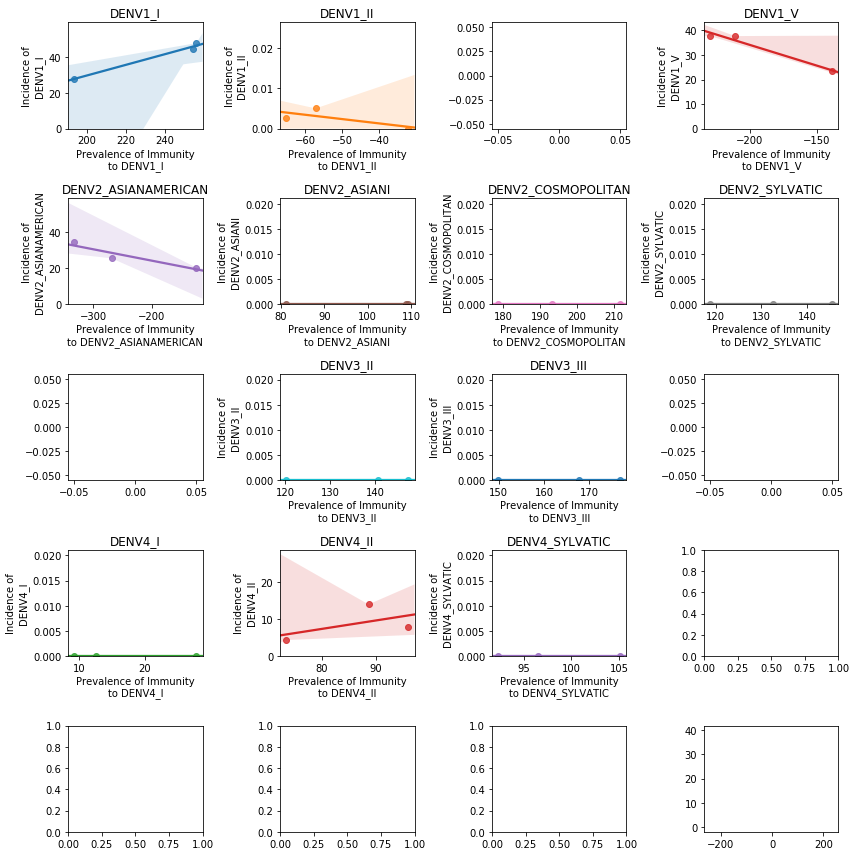

In [86]:
plot_all_the_things('genotype', 3)

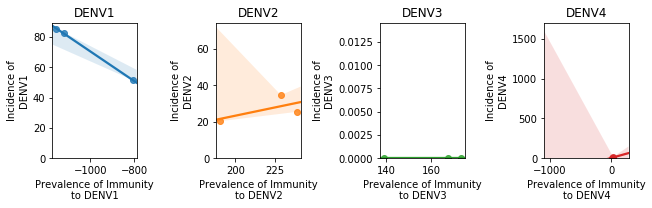

In [89]:
plot_all_the_things('serotype', 3)

In [91]:
'''
TO DO:

1 - Adjust frequency values (take out sylvatic strains, figure out why DENV3 doesn't show up in later seasons)
2 - Check the genotype titers csv (why are there so many large negative values here?)
3 - Figure out the units on "prevalence of immunity"
4 - Follow up w/ Eva + Leah re: additional case count data
5 - Weight the cumulative incidence values by gamma function to simulate waning immunity over time
'''
pass